In [3]:
import numpy as np
import pandas as pd
import os
import sys
import math
import random
import shutil

import cv2
import pydicom
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from ultralytics import YOLO
import wandb

np.random.seed(42)

In [5]:
output = pd.read_csv('submission.csv')
output.head(50)

patientId  \
0   0000a175-0e68-4ca4-b1af-167204a7e0bc   
1   0005d3cc-3c3f-40b9-93c3-46231c3eb813   
2   000686d7-f4fc-448d-97a0-44fa9c5d3aa6   
3   000e3a7d-c0ca-4349-bb26-5af2d8993c3d   
4   00100a24-854d-423d-a092-edcf6179e061   
5   0015597f-2d69-4bc7-b642-5b5e01534676   
6   001b0c51-c7b3-45c1-9c17-fa7594cab96e   
7   0022bb50-bf6c-4185-843e-403a9cc1ea80   
8   00271e8e-aea8-4f0a-8a34-3025831f1079   
9   0028450f-5b8e-4695-9416-8340b6f686b0   
10  002bcde0-d8da-4931-ab04-5d724e30261b   
11  002fcb77-ef76-4626-ab34-5070f15c20db   
12  003206b4-bd4a-4684-8d49-76f4cb713a30   
13  00330f7f-d114-4eb2-9c6e-558eeb3084a1   
14  00342ae8-ff81-4229-adf6-6a2ab711707b   
15  003d17f0-bd8a-485c-bc8b-daec33f53efa   
16  003dba79-1b1d-4713-add8-d72c54074f8a   
17  003ec9e3-512e-4f6e-923d-daa9f9f3db9a   
18  003fbda2-ba55-4714-a03a-83f15bec19e4   
19  0041fc67-793c-4129-a952-ea3fb821b445   
20  00475531-1036-4ab4-8c12-1eac7e9ddfd1   
21  0048e89e-f88a-41a1-b79f-ab4e7135627e   
22  004b28ac-d188-427b-8a21-10501125f596   
23  004f0a0f-fb54-4068-8b67-d3eef6724f44   
24  004f720d-482c-4982-b866-1a327e51eaba   
25  0050f8bb-36a4-4a1a-8de5-2d73154c2571   
26  0051fc13-694d-43d4-bbca-5a185f90418f   
27  00525b72-7c03-4328-9c02-6393704810d8   
28  006081fc-cd84-4675-828a-784d2521fcc7   
29  00632296-ea6d-438e-982d-370b771a6059   
30  0066ba32-08b6-4ac9-8d5a-abec69825d53   
31  00679577-c370-4aff-ab2b-fc4846c3eabb   
32  0068492c-2cc4-46b3-9ac5-ccb80fc10c96   
33  006be30e-1295-4053-9ffc-fab6b527e7d9   
34  00722cea-8cb4-488c-91a1-402d3cfab7a3   
35  00748fc6-3e87-482a-a0b4-ca2b0a7686a3   
36  00763ba7-af28-4893-a403-08490fcdd69c   
37  0076e39f-5189-4751-8274-da6df4d5e429   
38  0076e68b-90cf-45da-a839-e67d3131182b   
39  00786b27-31a0-4aeb-8513-9528fffe7b87   
40  007d9048-a1f4-49ea-8fb1-f228dc4b6cda   
41  007f06ce-348d-421c-968b-8b35ccb3487c   
42  008102ab-5ea6-414d-bff1-9f55d148a80d   
43  00860e86-5b18-4694-a20a-0b47e842a453   
44  0086a7a6-c663-401a-a908-378e87ebe45a   
45  008ca187-f164-4a2b-b14e-29d4e16e3a66   
46  008efe9c-946b-4f43-ae07-942f8d73dcc1   
47  0092f442-ccb5-49a2-81cf-b6ca3f829a53   
48  0094bcae-2cdd-48ca-9630-7d4157f78415   
49  0094c2b8-5da2-4e25-a177-b4eea16bd671   

                                     PredictionString  
0                                                 NaN  
1                    0.31 384.00 287.21 118.81 178.98  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
9                    0.28 718.32 573.29 206.19 189.20  
10                   0.38 740.65 650.75 294.73 437.16  
11                                                NaN  
12                                                NaN  
13                   0.40 634.77 572.32 290.67 525.58  
14                                                NaN  
15                                                NaN  
16                                                NaN  
17                                                NaN  
18  0.45 741.10 475.09 280.28 453.82 0.25 368.90 5...  
19                                                NaN  
20                                                NaN  
21                   0.25 291.17 561.83 250.23 216.16  
22                                                NaN  
23                                                NaN  
24                                                NaN  
25                                                NaN  
26                                                NaN  
27                   0.36 741.89 591.70 303.63 436.01  
28                   0.28 290.74 711.12 171.76 250.55  
29  0.37 266.16 420.26 322.61 582.78 0.28 709.73 5...  
30                                                

In [25]:
def get_id_from_path(path):
    return os.path.splitext(os.path.basename(path))[0]

TEST_IMG_DIR = './test_images/'
test_list = os.listdir(TEST_IMG_DIR)
submission = pd.read_csv('submission.csv', index_col='patientId')

In [52]:
def plot_test_pred(image_file, verbose=True):
    demo_img_path = TEST_IMG_DIR + image_file
    patient_id = get_id_from_path(image_file)

    plt.imshow(cv2.imread(demo_img_path))

    coors = submission.loc[patient_id, 'PredictionString']
    if pd.notna(coors):
        coors_list = coors.split()
        for i in range(0, len(coors_list), 5):
            _, x, y, w, h = coors_list[i:i+5]
            x, y, w, h = float(x), float(y), float(w), float(h)
            x, y, w, h = int(x), int(y), int(w), int(h)
            plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='orange')
            if verbose:
                print(x, y, w, h)

<Figure size 640x480 with 0 Axes>

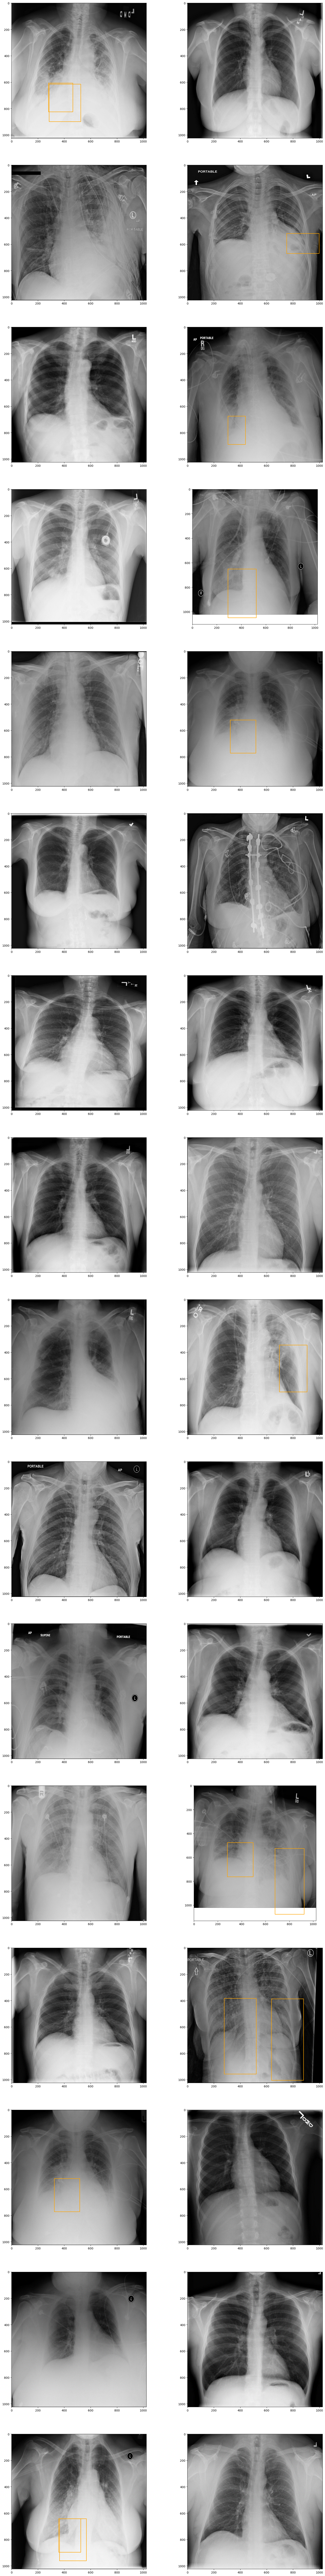

In [53]:
def plot_examples(image_list, rows = 5, cols = 2):
    plt.suptitle('Original test set')
    plt.figure(figsize=(10*cols,10*rows))
    for h in range(rows):
        for w in range(cols):
            plt.subplot(rows, cols, h*2+w+1)
            rand_image = random.choice(image_list)
            plot_test_pred(rand_image, verbose=False)

plot_examples(test_list, 16, 2)